In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats, integrate

import statsmodels.api as sm

history = pd.read_csv("sample_data/history_Si_2020_2022.csv", sep=";")
history = history.drop(["<OPEN>", "<LOW>", "<HIGH>", "<VOL>"], axis=1)
history["<DATE>"] = history["<DATE>"].astype("str")
history["<DTM>"] = pd.to_datetime(history["<DATE>"] + " " + history["<TIME>"], format="%Y%m%d %H:%M:%S")
history = history.drop(["<DATE>", "<TIME>"], axis=1)
history = history.set_index(history["<DTM>"])
history = history[1:]

history.tail()

,Unnamed: 0,<CLOSE>,<DTM>
<DTM>,,,
2022-01-26 23:25:00,3025,80417.0,2022-01-26 23:25:00
2022-01-26 23:30:00,3026,80603.0,2022-01-26 23:30:00
2022-01-26 23:35:00,3027,80631.0,2022-01-26 23:35:00
2022-01-26 23:40:00,3028,80564.0,2022-01-26 23:40:00
2022-01-26 23:45:00,3029,80488.0,2022-01-26 23:45:00


Введем параметры

In [3]:
ema_len = 50                      # период скользящей средней
T = 500                           # к-во 5-минутных баров до экспирации
bars_daily = 198                  # к-во 5-минутных баров в торговом дне
D_EXP = math.floor(T/bars_daily)  # дней до экспирации
Tmarket = 2                       # рыночное время до экспирации (дней?)

futures_price = 78000
option_strike = 77000

Рассчитаем лог-приращения и дисперсию

In [4]:
history["RET"] = np.log(history["<CLOSE>"]) - np.log(history["<CLOSE>"].shift(1))  # L(t)
history["VARIANCE"] = history["RET"] ** 2
history.tail()

,Unnamed: 0,<CLOSE>,<DTM>,RET,VARIANCE
<DTM>,,,,,
2022-01-26 23:25:00,3025,80417.0,2022-01-26 23:25:00,-0.001926,3.707928e-06
2022-01-26 23:30:00,3026,80603.0,2022-01-26 23:30:00,0.002310,5.337362e-06
2022-01-26 23:35:00,3027,80631.0,2022-01-26 23:35:00,0.000347,1.206321e-07
2022-01-26 23:40:00,3028,80564.0,2022-01-26 23:40:00,-0.000831,6.910453e-07
2022-01-26 23:45:00,3029,80488.0,2022-01-26 23:45:00,-0.000944,8.907483e-07


Рассчитаем веса баров на всем имеющемся наборе данных

In [5]:
bars_means = history.groupby([history.index.minute.rename("minute"), history.index.hour.rename("hour")])["VARIANCE"].mean()
bars_means

minute  hour
0       7       2.157096e-06
        8       1.144785e-07
        9       2.192721e-07
        10      2.180073e-05
        11      5.624944e-07
                    ...     
55      18      0.000000e+00
        19      5.488168e-07
        20      1.633946e-07
        21      1.866873e-07
        22      1.535035e-07
Name: VARIANCE, Length: 202, dtype: float64

In [6]:
sum_means = sum(bars_means)
bar_weights = bars_means / sum_means

bar_weights

minute  hour
0       7       0.023314
        8       0.001237
        9       0.002370
        10      0.235623
        11      0.006079
                  ...   
55      18      0.000000
        19      0.005932
        20      0.001766
        21      0.002018
        22      0.001659
Name: VARIANCE, Length: 202, dtype: float64

Проставим веса баров в общий датафрейм

In [8]:
history['Tkn'] = history.apply(lambda row: bar_weights[row["<DTM>"].minute][row["<DTM>"].hour], axis=1) # рыночное время пятиминутки, выраженное в сутках
history.head()

,Unnamed: 0,<CLOSE>,<DTM>,RET,VARIANCE,Tkn
<DTM>,,,,,,
2020-01-08 10:05:00,1,62406.0,2020-01-08 10:05:00,NaN,NaN,0.021800
2020-01-08 10:10:00,2,62320.0,2020-01-08 10:10:00,-0.001379,1.901705e-06,0.011782
2020-01-08 10:15:00,3,62331.0,2020-01-08 10:15:00,0.000176,3.114970e-08,0.008235
2020-01-08 10:20:00,4,62402.0,2020-01-08 10:20:00,0.001138,1.296027e-06,0.006622
2020-01-08 10:25:00,5,62366.0,2020-01-08 10:25:00,-0.000577,3.330110e-07,0.005805


Отнормируем сглаженную дисперсию на время до экспирации и рассчитаем "котопсевдовол" до экспирации (V)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0368966d0>]],
      dtype=object)

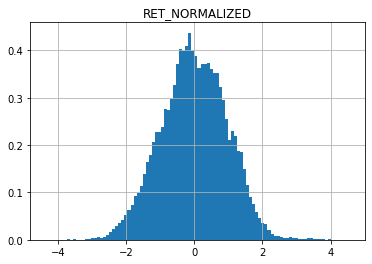

In [52]:
history["VARIANCE_WEIGHTED"] = history["VARIANCE"] / history["Tkn"]   # суточная волатильность
history["VARIANCE_SMOOTHED"] = history['VARIANCE_WEIGHTED'].ewm(span=ema_len,min_periods=ema_len,adjust=False,ignore_na=False).mean() # усреденная суточная волатильность
history = history.drop(history[history["VARIANCE_SMOOTHED"] == 0].index)    # убираем нулевые значения

# last_row_var_smoothed = history.iloc[-1]["VARIANCE_SMOOTHED"]

history["SMA_Tkn"] = history["Tkn"].rolling(T).mean()

# Ты скользишь окном T, за это окно набегает рыночного времени SMA(Tkn,T)*T 
history["RET_NORMALIZED"] = history["RET"].rolling(T).sum() / (history["VARIANCE_SMOOTHED"] * history["SMA_Tkn"] * T) ** 0.5

#history["RET_NORMALIZED"] = history["RET_NORMALIZED"]*history["VARIANCE_SMOOTHED"]*(Tmarket)**0.5
#history["RET_NORMALIZED"] = history["RET_NORMALIZED"].apply(lambda x: math.exp(x))
#history["RET_NORMALIZED"] = history["RET_NORMALIZED"] * futures_price
history.hist(column="RET_NORMALIZED", bins=100, density=True)

Сглаживание

In [53]:
kde = sm.nonparametric.KDEUnivariate(history["RET_NORMALIZED"])
kde.fit()

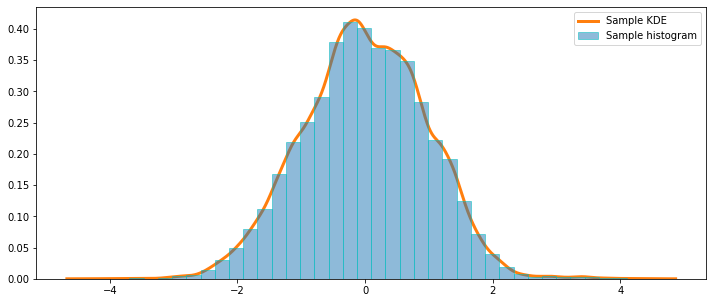

In [54]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.hist(
    history["RET_NORMALIZED"],
    bins=40,
    label="Sample histogram",
    zorder=5,
    edgecolor="c",
    density=True,
    alpha=0.5
)
ax.plot(kde.support, kde.density, lw=3, label="Sample KDE")
ax.legend(loc="best")
plt.show()

Рассчитаем цену опциона колл страйк 77000 цена фьючерса 78000, до экспирации примерно 3-е суток (500 баров M5)

In [19]:
call_price = integrate.quad(lambda x: kde.evaluate(x)*D_EXP**0.5, futures_price/option_strike, np.inf)
call_price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  """Entry point for launching an IPython kernel.


(nan, nan)